# Makespan policies

In this notebook, we compare various heterogeneity-agnostic and heterogeneity-aware makespan policies, with and without space sharing.

## Import statements

In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=2,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
from utils import get_logfile_paths, makespan_fn, prune

## Get list of relevant logfiles and define label mapping

In [3]:
logfile_paths = sorted(
    get_logfile_paths(
        "/future/u/deepakn/gavel/logs/multi_gpu_static_jobs_final/", static_trace=True))

In [4]:
labels = {"fifo": "FIFO",
          "gandiva": "Gandiva",
          "min_total_duration": "Gavel",
          "min_total_duration_packed": "Gavel w/ SS"}

## Plotting functions

In [5]:
def plot_metric_vs_num_total_jobs(logfile_paths,
                                  labels,
                                  v100s, p100s, k80s, policies, metric_fn,
                                  metric_label, xmax=None, ymax=None,
                                  output_filename=None):
    plt.figure(figsize=(8, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"num_total_jobs": [], "metric": [], "seed": [],
            "policy": []}
    for policy in policies:
        relevant_logfile_paths = list(reversed(prune(
            logfile_paths, v100s, p100s, k80s, policy)))
        num_total_jobs = [x[0] for x in relevant_logfile_paths]
        metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
        seeds = [x[2] for x in relevant_logfile_paths]
        policies = [labels[policy] for i in range(len(metrics))]

        import pandas as pd
        data["num_total_jobs"] += num_total_jobs
        data["metric"] += metrics
        data["seed"] += seeds
        data["policy"] += policies
    import pandas as pd
    df = pd.DataFrame(data)
    print(df.groupby(["policy", "num_total_jobs"]).mean())

    sns.lineplot(x='num_total_jobs', y='metric', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Number of jobs")
    ax.set_ylabel(metric_label)
    ax.set_xlim([70, xmax])
    ax.set_xticks([100, 200, 300, 400, 500, 600, 700])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    leg = plt.legend(frameon=False)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.22
    bb.y1 += 0.22
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

## Plot makespan vs. number of jobs

V100s=36, P100s=36, K80s=36
                                metric  seed
policy      num_total_jobs                  
FIFO        100.0           182.319456     1
            200.0           229.430326     1
            300.0           295.563378     1
            400.0           350.496270     1
            500.0           426.584611     1
            600.0           506.228073     1
            700.0           619.518289     1
Gandiva     100.0           166.610363     1
            200.0           178.881487     1
            300.0           199.872284     1
            400.0           224.099920     1
            500.0           263.865740     1
            600.0           301.279455     1
            700.0           347.335019     1
Gavel       100.0           161.163998     1
            200.0           161.164065     1
            300.0           161.164303     1
            400.0           161.291139     1
            500.0           169.422498     1
            600.0          

/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


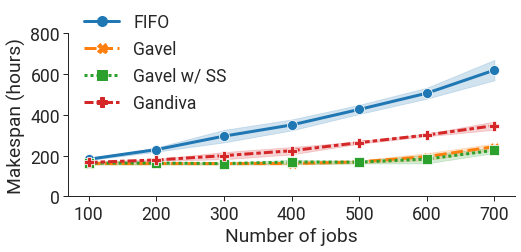

In [6]:
print("V100s=36, P100s=36, K80s=36")
plot_metric_vs_num_total_jobs(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    policies=["fifo", "min_total_duration", "min_total_duration_packed", "gandiva"],
    metric_fn=makespan_fn,
    metric_label="Makespan (hours)",
    xmax=None,
    ymax=800,
    output_filename="makespan/multi_gpu_v100=36_p100=36_k80=36.pdf"
)